In [1]:
import os
import gc
import sys
import time
import h5py
import torch
import numpy as np
import pandas as pd
from numpy.lib.function_base import corrcoef
import nibabel as nib
from nilearn import image, surface, plotting, datasets

from sklearn.metrics import pairwise_distances
import scipy.sparse as sps
import scipy as sp
from scipy.sparse.linalg import eigsh, eigs
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

from scipy import stats
from scipy.stats import pearsonr

from matplotlib import font_manager
font_manager.fontManager.addfont("/n02dat01/users/lchai/anaconda3/envs/Nm/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/arial.ttf")
plt.rcParams["font.sans-serif"] = "Arial" 

/n01dat01/dyli/soft/miniconda3/envs/pynb/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
# read the basic info
dirc_L = '/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = '/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

In [3]:
# 读取梯度数据
emb_L = np.load('/n02dat01/users/dyli/Grad_data/sc/MPC_Grad_results/MPC_sc_vertex_volume_100_embedding_dense_emb_L_zeros.npy')
emb_R = np.load('/n02dat01/users/dyli/Grad_data/sc/MPC_Grad_results/MPC_sc_vertex_volume_100_embedding_dense_emb_R_zeros.npy')
emb = np.zeros((59412, 3))
emb[0:29696, :] = emb_L[:, 0:3]
emb[29696:59412, :] = emb_R[:, 0:3]
print(emb.shape)

(59412, 3)


In [4]:
gene_father = '/n02dat01/users/dyli/Grad_data/support_data/Gene_results'

# Left brain

FOXG1:0.702313496213002;0.18602014742794748
FGF17:-0.9077167619268995;0.03318281512890894
FOXG1:0.6181881487674958;0.05678480729547628
FGF17:-0.8943300809084834;0.00047931569952576
FOXG1:0.5838300218821615;0.006878397592317348
FGF17:-0.7980494603137255;2.4830881244942827e-05


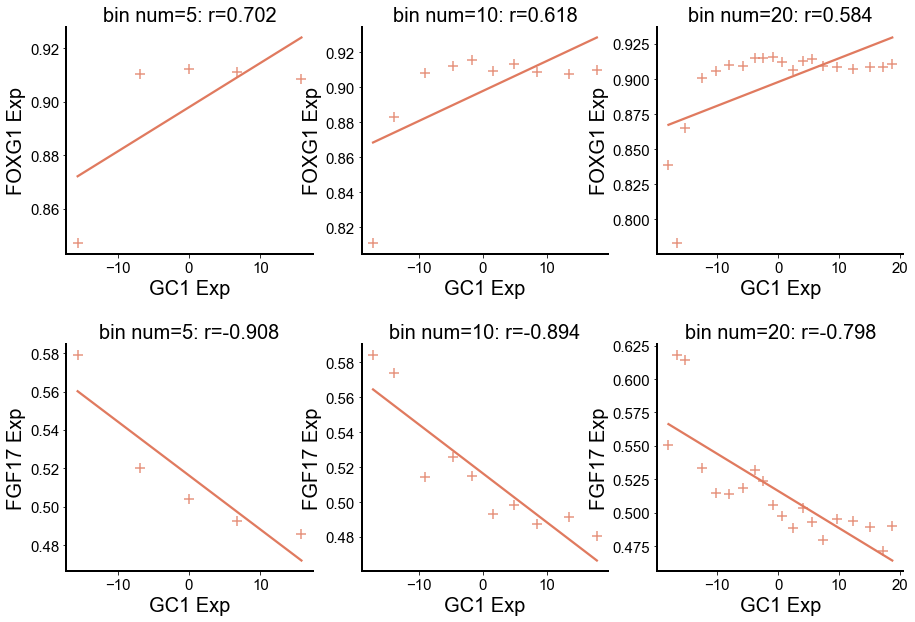

In [5]:
gene_name_1 = 'FOXG1'
gene_name_2 = 'FGF17'
gene_L = surface.load_surf_data(f'{gene_father}/GIFTI_L/{gene_name_1}.L.func.gii')
gene_R = surface.load_surf_data(f'{gene_father}/GIFTI_R/{gene_name_1}.R.func.gii')
gene_1 = np.concatenate([gene_L[select_ind_L], gene_R[select_ind_R]])

gene_L = surface.load_surf_data(f'{gene_father}/GIFTI_L/{gene_name_2}.L.func.gii')
gene_R = surface.load_surf_data(f'{gene_father}/GIFTI_R/{gene_name_2}.R.func.gii')
gene_2 = np.concatenate([gene_L[select_ind_L], gene_R[select_ind_R]])

GC = emb[:,0]

fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.4)
for bin_num in [5,10,20]:
    gene_1_bin = np.zeros(bin_num)
    gene_2_bin = np.zeros(bin_num)
    GC_bin = np.zeros(bin_num)

    for _bin in range(bin_num):
        # left hemisphere
        idx = np.argsort(emb_L[:, 0])[_bin*int(emb_L.shape[0]/bin_num):(_bin+1)*int(emb_L.shape[0]/bin_num)]
        gene_1_bin[_bin] = np.mean(gene_1[idx])
        gene_2_bin[_bin] = np.mean(gene_2[idx])
        GC_bin[_bin] = np.mean(emb_L[idx, 0])

    r1,p1 = pearsonr(gene_1_bin, GC_bin)
    r2,p2 = pearsonr(gene_2_bin, GC_bin)
    print(f'{gene_name_1}:{r1};{p1}\n{gene_name_2}:{r2};{p2}')

    tips = pd.DataFrame({'y':gene_1_bin, 'x':GC_bin})
    if bin_num== 5: ax = fig.add_subplot(231)
    if bin_num==10: ax = fig.add_subplot(232)
    if bin_num==20: ax = fig.add_subplot(233)
    fig = sns.regplot(x="x", y="y", \
                data=tips, \
                scatter_kws={'s':100}, \
                line_kws={'linestyle':'-'}, \
                ci = None, \
                marker='+', color='#E07A5f')
    plt.xlabel(f"GC1 Exp", fontsize=20)
    plt.ylabel(f"{gene_name_1} Exp", fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth('2.0')
    ax.spines['left'].set_linewidth('2.0')
    ax.tick_params(labelsize=15)
    fig = fig.get_figure()
    plt.title(f'bin num={bin_num}: r={np.round(r1,3)}', fontsize=20)

    tips = pd.DataFrame({'y':gene_2_bin, 'x':GC_bin})
    if bin_num== 5: ax = fig.add_subplot(234)
    if bin_num==10: ax = fig.add_subplot(235)
    if bin_num==20: ax = fig.add_subplot(236)
    fig = sns.regplot(x="x", y="y", \
                data=tips, \
                scatter_kws={'s':100}, \
                line_kws={'linestyle':'-'}, \
                ci = None, \
                marker='+', color='#E07A5f')
    plt.xlabel(f"GC1 Exp", fontsize=20)
    plt.ylabel(f"{gene_name_2} Exp", fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth('2.0')
    ax.spines['left'].set_linewidth('2.0')
    ax.tick_params(labelsize=15)
    fig = fig.get_figure()
    plt.title(f'bin num={bin_num}: r={np.round(r2,3)}', fontsize=20)
plt.show()

FGF8:0.8858026399083597;0.04552345981212451
PAX6:-0.8143586177163882;0.09329684568293513
FGF8:0.7945287939110609;0.006035042493152109
PAX6:-0.7601638088520528;0.010711545500698264
FGF8:0.7543941185431015;0.00012154555113893458
PAX6:-0.6950687675286614;0.0006696057720779227


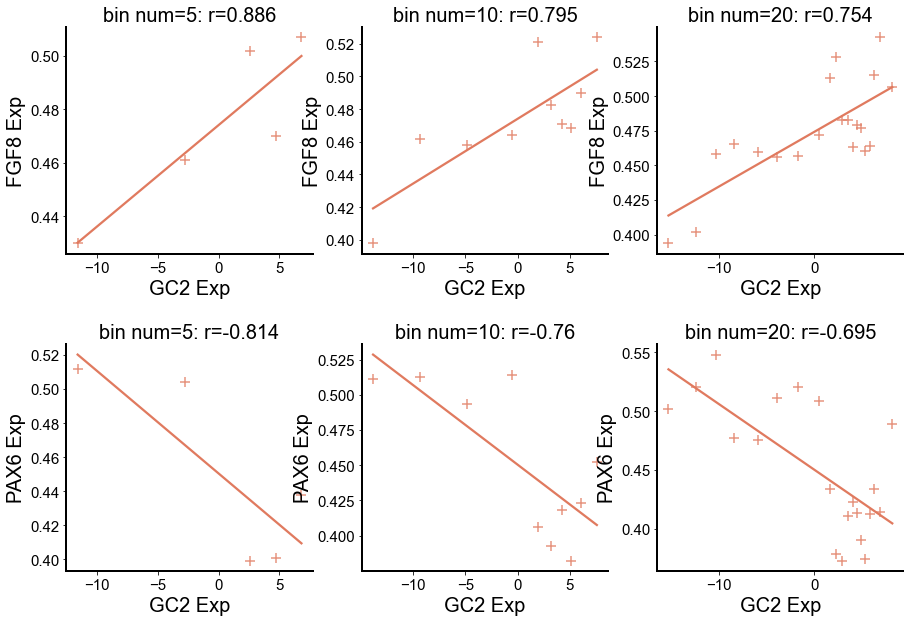

In [6]:
gene_name_1 = 'FGF8'
gene_name_2 = 'PAX6'
gene_L = surface.load_surf_data(f'{gene_father}/GIFTI_L/{gene_name_1}.L.func.gii')
gene_R = surface.load_surf_data(f'{gene_father}/GIFTI_R/{gene_name_1}.R.func.gii')
gene_1 = np.concatenate([gene_L[select_ind_L], gene_R[select_ind_R]])

gene_L = surface.load_surf_data(f'{gene_father}/GIFTI_L/{gene_name_2}.L.func.gii')
gene_R = surface.load_surf_data(f'{gene_father}/GIFTI_R/{gene_name_2}.R.func.gii')
gene_2 = np.concatenate([gene_L[select_ind_L], gene_R[select_ind_R]])

gg=1
GC = emb[:,gg]

fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.4)
for bin_num in [5,10,20]:
    gene_1_bin = np.zeros(bin_num)
    gene_2_bin = np.zeros(bin_num)
    GC_bin = np.zeros(bin_num)

    for _bin in range(bin_num):
        # left hemisphere
        idx = np.argsort(emb_L[:, gg])[_bin*int(emb_L.shape[0]/bin_num):(_bin+1)*int(emb_L.shape[0]/bin_num)]
        gene_1_bin[_bin] = np.mean(gene_1[idx])
        gene_2_bin[_bin] = np.mean(gene_2[idx])
        GC_bin[_bin] = np.mean(emb_L[idx, gg])

    r1,p1 = pearsonr(gene_1_bin, GC_bin)
    r2,p2 = pearsonr(gene_2_bin, GC_bin)
    print(f'{gene_name_1}:{r1};{p1}\n{gene_name_2}:{r2};{p2}')

    tips = pd.DataFrame({'y':gene_1_bin, 'x':GC_bin})
    if bin_num== 5: ax = fig.add_subplot(231)
    if bin_num==10: ax = fig.add_subplot(232)
    if bin_num==20: ax = fig.add_subplot(233)
    fig = sns.regplot(x="x", y="y", \
                data=tips, \
                scatter_kws={'s':100}, \
                line_kws={'linestyle':'-'}, \
                ci = None, \
                marker='+', color='#E07A5f')
    plt.xlabel(f"GC{gg+1} Exp", fontsize=20)
    plt.ylabel(f"{gene_name_1} Exp", fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth('2.0')
    ax.spines['left'].set_linewidth('2.0')
    ax.tick_params(labelsize=15)
    fig = fig.get_figure()
    plt.title(f'bin num={bin_num}: r={np.round(r1,3)}', fontsize=20)

    tips = pd.DataFrame({'y':gene_2_bin, 'x':GC_bin})
    if bin_num== 5: ax = fig.add_subplot(234)
    if bin_num==10: ax = fig.add_subplot(235)
    if bin_num==20: ax = fig.add_subplot(236)
    fig = sns.regplot(x="x", y="y", \
                data=tips, \
                scatter_kws={'s':100}, \
                line_kws={'linestyle':'-'}, \
                ci = None, \
                marker='+', color='#E07A5f')
    plt.xlabel(f"GC{gg+1} Exp", fontsize=20)
    plt.ylabel(f"{gene_name_2} Exp", fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth('2.0')
    ax.spines['left'].set_linewidth('2.0')
    ax.tick_params(labelsize=15)
    fig = fig.get_figure()
    plt.title(f'bin num={bin_num}: r={np.round(r2,3)}', fontsize=20)
plt.show()

SFRP1:0.9076126330973634;0.03323845882995071
WNT3:-0.9630957535155482;0.008463101939224749
SFRP1:0.7809904060038618;0.0076539315273857515
WNT3:-0.7623592362168576;0.01035450987492864
SFRP1:0.7307769140816581;0.0002525232220071237
WNT3:-0.7267249754481092;0.0002841581090604986


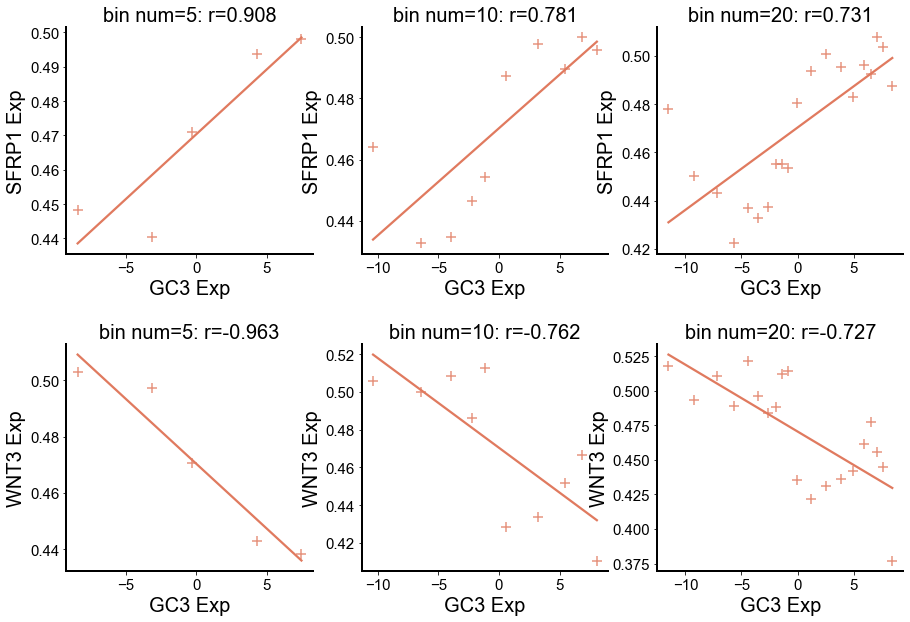

In [7]:
gene_name_1 = 'SFRP1'
gene_name_2 = 'WNT3'
gene_L = surface.load_surf_data(f'{gene_father}/GIFTI_L/{gene_name_1}.L.func.gii')
gene_R = surface.load_surf_data(f'{gene_father}/GIFTI_R/{gene_name_1}.R.func.gii')
gene_1 = np.concatenate([gene_L[select_ind_L], gene_R[select_ind_R]])

gene_L = surface.load_surf_data(f'{gene_father}/GIFTI_L/{gene_name_2}.L.func.gii')
gene_R = surface.load_surf_data(f'{gene_father}/GIFTI_R/{gene_name_2}.R.func.gii')
gene_2 = np.concatenate([gene_L[select_ind_L], gene_R[select_ind_R]])

gg=2
GC = emb[:,gg]

fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.4)
for bin_num in [5,10,20]:
    gene_1_bin = np.zeros(bin_num)
    gene_2_bin = np.zeros(bin_num)
    GC_bin = np.zeros(bin_num)

    for _bin in range(bin_num):
        # left hemisphere
        idx = np.argsort(emb_L[:, gg])[_bin*int(emb_L.shape[0]/bin_num):(_bin+1)*int(emb_L.shape[0]/bin_num)]
        gene_1_bin[_bin] = np.mean(gene_1[idx])
        gene_2_bin[_bin] = np.mean(gene_2[idx])
        GC_bin[_bin] = np.mean(emb_L[idx, gg])

    r1,p1 = pearsonr(gene_1_bin, GC_bin)
    r2,p2 = pearsonr(gene_2_bin, GC_bin)
    print(f'{gene_name_1}:{r1};{p1}\n{gene_name_2}:{r2};{p2}')

    tips = pd.DataFrame({'y':gene_1_bin, 'x':GC_bin})
    if bin_num== 5: ax = fig.add_subplot(231)
    if bin_num==10: ax = fig.add_subplot(232)
    if bin_num==20: ax = fig.add_subplot(233)
    fig = sns.regplot(x="x", y="y", \
                data=tips, \
                scatter_kws={'s':100}, \
                line_kws={'linestyle':'-'}, \
                ci = None, \
                marker='+', color='#E07A5f')
    plt.xlabel(f"GC{gg+1} Exp", fontsize=20)
    plt.ylabel(f"{gene_name_1} Exp", fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth('2.0')
    ax.spines['left'].set_linewidth('2.0')
    ax.tick_params(labelsize=15)
    fig = fig.get_figure()
    plt.title(f'bin num={bin_num}: r={np.round(r1,3)}', fontsize=20)

    tips = pd.DataFrame({'y':gene_2_bin, 'x':GC_bin})
    if bin_num== 5: ax = fig.add_subplot(234)
    if bin_num==10: ax = fig.add_subplot(235)
    if bin_num==20: ax = fig.add_subplot(236)
    fig = sns.regplot(x="x", y="y", \
                data=tips, \
                scatter_kws={'s':100}, \
                line_kws={'linestyle':'-'}, \
                ci = None, \
                marker='+', color='#E07A5f')
    plt.xlabel(f"GC{gg+1} Exp", fontsize=20)
    plt.ylabel(f"{gene_name_2} Exp", fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth('2.0')
    ax.spines['left'].set_linewidth('2.0')
    ax.tick_params(labelsize=15)
    fig = fig.get_figure()
    plt.title(f'bin num={bin_num}: r={np.round(r2,3)}', fontsize=20)
plt.show()

# whole brain

## GC1

FOXG1:0.5349136968854733;0.11112269058247884
FGF17:-0.7969104787766256;0.005777862172617304
FOXG1:0.488781642353586;0.028749531400774075
FGF17:-0.7789592050831995;5.19201832719974e-05
FOXG1:0.4634078980448072;0.002600031564082019
FGF17:-0.6898328002780431;8.482741535053187e-07


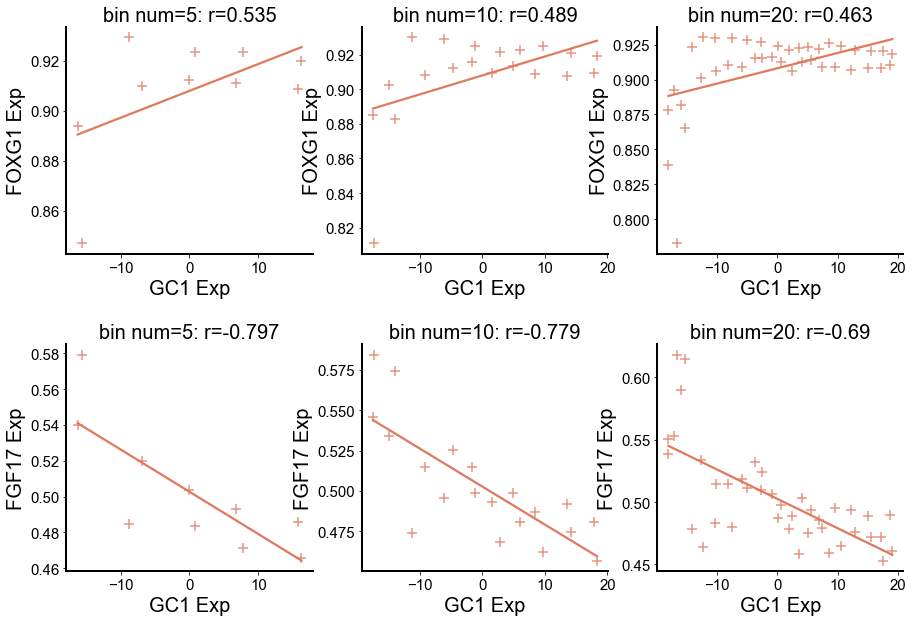

In [11]:
gene_name_1 = 'FOXG1'
gene_name_2 = 'FGF17'
gene_L = surface.load_surf_data(f'{gene_father}/GIFTI_L/{gene_name_1}.L.func.gii')
gene_R = surface.load_surf_data(f'{gene_father}/GIFTI_R/{gene_name_1}.R.func.gii')
gene_1 = np.concatenate([gene_L[select_ind_L], gene_R[select_ind_R]])

gene_L = surface.load_surf_data(f'{gene_father}/GIFTI_L/{gene_name_2}.L.func.gii')
gene_R = surface.load_surf_data(f'{gene_father}/GIFTI_R/{gene_name_2}.R.func.gii')
gene_2 = np.concatenate([gene_L[select_ind_L], gene_R[select_ind_R]])

GC = emb[:,0]

fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.4)
for bin_num in [5,10,20]:
    gene_1_bin = np.zeros(bin_num*2)
    gene_2_bin = np.zeros(bin_num*2)
    GC_bin = np.zeros(bin_num*2)

    for _bin in range(bin_num):
        # left hemisphere
        idx = np.argsort(emb_L[:, 0])[_bin*int(emb_L.shape[0]/bin_num):(_bin+1)*int(emb_L.shape[0]/bin_num)]
        gene_1_bin[_bin] = np.mean(gene_1[idx])
        gene_2_bin[_bin] = np.mean(gene_2[idx])
        GC_bin[_bin] = np.mean(emb_L[idx, 0])
        # right hemisphere
        idx = np.argsort(emb_R[:, 0])[_bin*int(emb_R.shape[0]/bin_num):(_bin+1)*int(emb_R.shape[0]/bin_num)]
        gene_1_bin[_bin + bin_num] = np.mean(gene_1[idx+29696])
        gene_2_bin[_bin + bin_num] = np.mean(gene_2[idx+29696])
        GC_bin[_bin + bin_num] = np.mean(emb_R[idx, 0])

    r1,p1 = pearsonr(gene_1_bin, GC_bin)
    r2,p2 = pearsonr(gene_2_bin, GC_bin)
    print(f'{gene_name_1}:{r1};{p1}\n{gene_name_2}:{r2};{p2}')

    tips = pd.DataFrame({'y':gene_1_bin, 'x':GC_bin})
    if bin_num== 5: ax = fig.add_subplot(231)
    if bin_num==10: ax = fig.add_subplot(232)
    if bin_num==20: ax = fig.add_subplot(233)
    fig = sns.regplot(x="x", y="y", \
                data=tips, \
                scatter_kws={'s':100}, \
                line_kws={'linestyle':'-'}, \
                ci = None, \
                marker='+', color='#E07A5f')
    plt.xlabel(f"GC1 Exp", fontsize=20)
    plt.ylabel(f"{gene_name_1} Exp", fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth('2.0')
    ax.spines['left'].set_linewidth('2.0')
    ax.tick_params(labelsize=15)
    fig = fig.get_figure()
    plt.title(f'bin num={bin_num}: r={np.round(r1,3)}', fontsize=20)

    tips = pd.DataFrame({'y':gene_2_bin, 'x':GC_bin})
    if bin_num== 5: ax = fig.add_subplot(234)
    if bin_num==10: ax = fig.add_subplot(235)
    if bin_num==20: ax = fig.add_subplot(236)
    fig = sns.regplot(x="x", y="y", \
                data=tips, \
                scatter_kws={'s':100}, \
                line_kws={'linestyle':'-'}, \
                ci = None, \
                marker='+', color='#E07A5f')
    plt.xlabel(f"GC1 Exp", fontsize=20)
    plt.ylabel(f"{gene_name_2} Exp", fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth('2.0')
    ax.spines['left'].set_linewidth('2.0')
    ax.tick_params(labelsize=15)
    fig = fig.get_figure()
    plt.title(f'bin num={bin_num}: r={np.round(r2,3)}', fontsize=20)
plt.show()

FOXG1:0.6181881487674958;0.05678480729547628
FGF17:-0.8943300809084834;0.00047931569952576


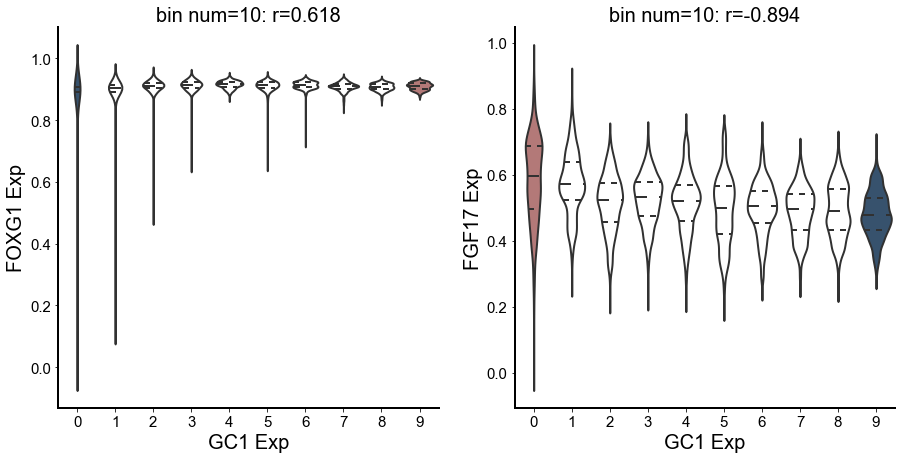

In [74]:
gene_name_1 = 'FOXG1'
gene_name_2 = 'FGF17'
gene_L = surface.load_surf_data(f'{gene_father}/GIFTI_L/{gene_name_1}.L.func.gii')
gene_R = surface.load_surf_data(f'{gene_father}/GIFTI_R/{gene_name_1}.R.func.gii')
gene_1 = np.concatenate([gene_L[select_ind_L], gene_R[select_ind_R]])

gene_L = surface.load_surf_data(f'{gene_father}/GIFTI_L/{gene_name_2}.L.func.gii')
gene_R = surface.load_surf_data(f'{gene_father}/GIFTI_R/{gene_name_2}.R.func.gii')
gene_2 = np.concatenate([gene_L[select_ind_L], gene_R[select_ind_R]])

gg=0
GC = emb[0:29696,gg]
gene_1 = gene_1[0:29696]
gene_2 = gene_2[0:29696]


fig = plt.figure(figsize=(15,7))
fig.subplots_adjust(hspace=0.4)
for bin_num in [10]:
    gene_1_bin = np.zeros(bin_num)
    gene_2_bin = np.zeros(bin_num)
    GC_bin = np.zeros(bin_num)
    gene_1_violin = np.zeros((29696, 2))
    gene_2_violin = np.zeros((29696, 2))

    for _bin in range(bin_num):
        # left hemisphere
        idx = np.argsort(emb_L[:, gg])[_bin*int(emb_L.shape[0]/bin_num):(_bin+1)*int(emb_L.shape[0]/bin_num)]
        gene_1_bin[_bin] = np.mean(gene_1[idx])
        gene_2_bin[_bin] = np.mean(gene_2[idx])
        GC_bin[_bin] = np.mean(emb_L[idx, gg])

        # violin
        gene_1_violin[idx,0] = int(_bin)
        gene_1_violin[idx,1] = gene_1[idx]
        gene_2_violin[idx,0] = int(_bin)
        gene_2_violin[idx,1] = gene_2[idx]

    r1,p1 = pearsonr(gene_1_bin, GC_bin)
    r2,p2 = pearsonr(gene_2_bin, GC_bin)
    print(f'{gene_name_1}:{r1};{p1}\n{gene_name_2}:{r2};{p2}')

    colors = ['#2e5276'] + ['#FFFFFF' for _ in range(bin_num-2)] + ['#bd706e']
    if bin_num==10: ax = fig.add_subplot(121)

    df = pd.DataFrame(np.array(gene_1_violin), columns=['bin','gene_exp'])
    df['bin'] = np.array(df['bin']).astype(np.int16)
    sns.violinplot(x ='bin', # 指定x轴的数据
               y = 'gene_exp', # 指定y轴的数据
               data = df, # 指定绘图的数据集
               orient='v',
               palette = colors,
               saturation = 0.75,
               bw='scott',
               inner='quartiles',
               linewidth=2)
    # plt.ylim(0.8,1)
    plt.xlabel(f"GC{gg+1} Exp", fontsize=20)
    plt.ylabel(f"{gene_name_1} Exp", fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth('2.0')
    ax.spines['left'].set_linewidth('2.0')
    ax.tick_params(labelsize=15)
    fig = fig.get_figure()
    plt.title(f'bin num={bin_num}: r={np.round(r1,3)}', fontsize=20)

    colors = ['#bd706e'] + ['#ffffff' for _ in range(bin_num-2)] + ['#2e5276']
    if bin_num==10: ax = fig.add_subplot(122)

    df = pd.DataFrame(np.array(gene_2_violin), columns=['bin','gene_exp'])
    df['bin'] = np.array(df['bin']).astype(np.int16)
    sns.violinplot(x ='bin', # 指定x轴的数据
               y = 'gene_exp', # 指定y轴的数据
               data = df, # 指定绘图的数据集
               orient='v',
               palette = colors,
               saturation = 0.75,
               bw='scott',
               inner='quartiles',
               linewidth=2)
    # plt.ylim(0.4,0.6)
    plt.xlabel(f"GC{gg+1} Exp", fontsize=20)
    plt.ylabel(f"{gene_name_2} Exp", fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth('2.0')
    ax.spines['left'].set_linewidth('2.0')
    ax.tick_params(labelsize=15)
    fig = fig.get_figure()
    plt.title(f'bin num={bin_num}: r={np.round(r2,3)}', fontsize=20)
plt.show()

## GC2


FGF8:0.5606530307562936;0.09181239421313037
PAX6:-0.7643504656305928;0.010038000876784825
FGF8:0.5595800164220003;0.010303198828564526
PAX6:-0.7170034934115475;0.0003741365647183433
FGF8:0.5357371834895294;0.0003672408603378078
PAX6:-0.6702222805988495;2.235767694417111e-06


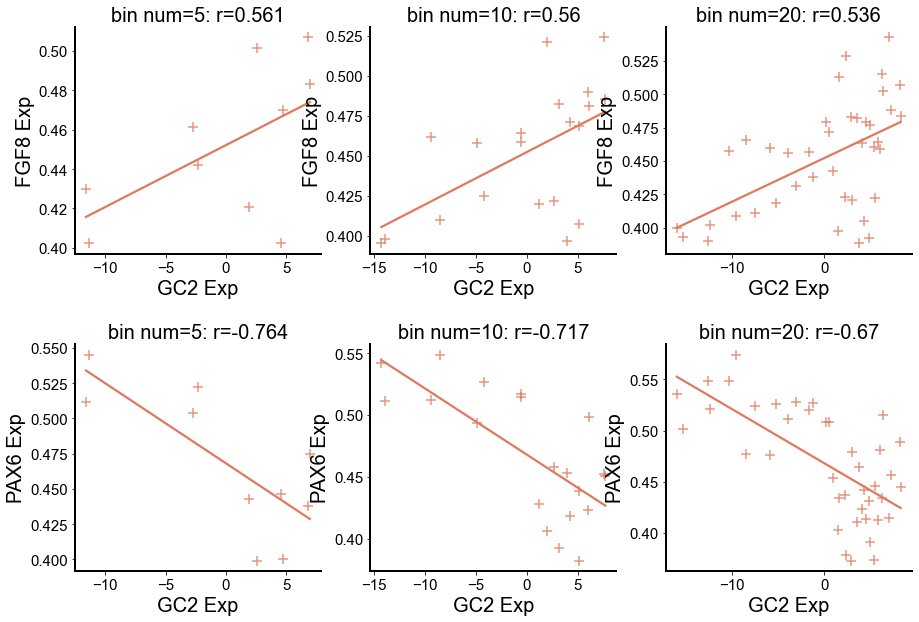

In [11]:
gene_name_1 = 'FGF8'
gene_name_2 = 'PAX6'
gene_L = surface.load_surf_data(f'{gene_father}/GIFTI_L/{gene_name_1}.L.func.gii')
gene_R = surface.load_surf_data(f'{gene_father}/GIFTI_R/{gene_name_1}.R.func.gii')
gene_1 = np.concatenate([gene_L[select_ind_L], gene_R[select_ind_R]])

gene_L = surface.load_surf_data(f'{gene_father}/GIFTI_L/{gene_name_2}.L.func.gii')
gene_R = surface.load_surf_data(f'{gene_father}/GIFTI_R/{gene_name_2}.R.func.gii')
gene_2 = np.concatenate([gene_L[select_ind_L], gene_R[select_ind_R]])

gg=1
GC = emb[:,gg]

fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.4)
for bin_num in [5,10,20]:
    gene_1_bin = np.zeros(bin_num*2)
    gene_2_bin = np.zeros(bin_num*2)
    GC_bin = np.zeros(bin_num*2)

    for _bin in range(bin_num):
        # left hemisphere
        idx = np.argsort(emb_L[:, gg])[_bin*int(emb_L.shape[0]/bin_num):(_bin+1)*int(emb_L.shape[0]/bin_num)]
        gene_1_bin[_bin] = np.mean(gene_1[idx])
        gene_2_bin[_bin] = np.mean(gene_2[idx])
        GC_bin[_bin] = np.mean(emb_L[idx, gg])
        # right hemisphere
        idx = np.argsort(emb_R[:, gg])[_bin*int(emb_R.shape[0]/bin_num):(_bin+1)*int(emb_R.shape[0]/bin_num)]
        gene_1_bin[_bin + bin_num] = np.mean(gene_1[idx+29696])
        gene_2_bin[_bin + bin_num] = np.mean(gene_2[idx+29696])
        GC_bin[_bin + bin_num] = np.mean(emb_R[idx, gg])

    r1,p1 = pearsonr(gene_1_bin, GC_bin)
    r2,p2 = pearsonr(gene_2_bin, GC_bin)
    print(f'{gene_name_1}:{r1};{p1}\n{gene_name_2}:{r2};{p2}')

    tips = pd.DataFrame({'y':gene_1_bin, 'x':GC_bin})
    if bin_num== 5: ax = fig.add_subplot(231)
    if bin_num==10: ax = fig.add_subplot(232)
    if bin_num==20: ax = fig.add_subplot(233)
    fig = sns.regplot(x="x", y="y", \
                data=tips, \
                scatter_kws={'s':100}, \
                line_kws={'linestyle':'-'}, \
                ci = None, \
                marker='+', color='#E07A5f')
    plt.xlabel(f"GC{gg+1} Exp", fontsize=20)
    plt.ylabel(f"{gene_name_1} Exp", fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth('2.0')
    ax.spines['left'].set_linewidth('2.0')
    ax.tick_params(labelsize=15)
    fig = fig.get_figure()
    plt.title(f'bin num={bin_num}: r={np.round(r1,3)}', fontsize=20)

    tips = pd.DataFrame({'y':gene_2_bin, 'x':GC_bin})
    if bin_num== 5: ax = fig.add_subplot(234)
    if bin_num==10: ax = fig.add_subplot(235)
    if bin_num==20: ax = fig.add_subplot(236)
    fig = sns.regplot(x="x", y="y", \
                data=tips, \
                scatter_kws={'s':100}, \
                line_kws={'linestyle':'-'}, \
                ci = None, \
                marker='+', color='#E07A5f')
    plt.xlabel(f"GC{gg+1} Exp", fontsize=20)
    plt.ylabel(f"{gene_name_2} Exp", fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth('2.0')
    ax.spines['left'].set_linewidth('2.0')
    ax.tick_params(labelsize=15)
    fig = fig.get_figure()
    plt.title(f'bin num={bin_num}: r={np.round(r2,3)}', fontsize=20)
plt.show()

FGF8:0.7945287939110609;0.006035042493152109
PAX6:-0.7601638088520528;0.010711545500698264


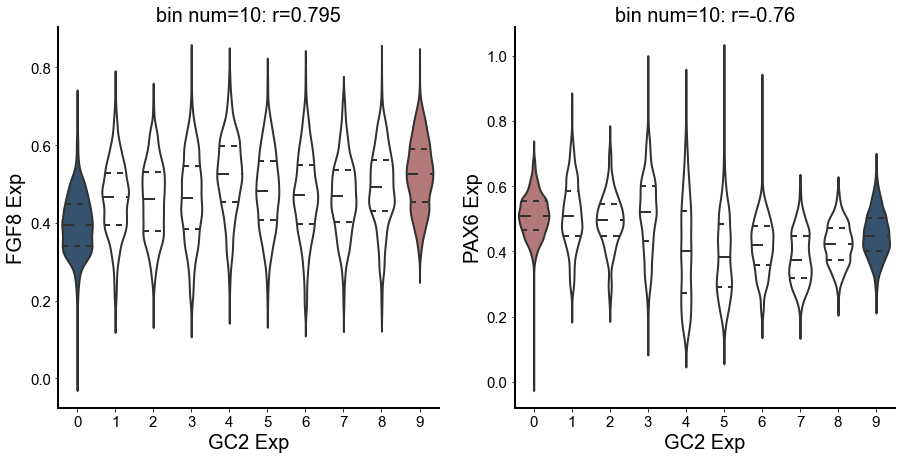

In [75]:
gene_name_1 = 'FGF8'
gene_name_2 = 'PAX6'
gene_L = surface.load_surf_data(f'{gene_father}/GIFTI_L/{gene_name_1}.L.func.gii')
gene_R = surface.load_surf_data(f'{gene_father}/GIFTI_R/{gene_name_1}.R.func.gii')
gene_1 = np.concatenate([gene_L[select_ind_L], gene_R[select_ind_R]])

gene_L = surface.load_surf_data(f'{gene_father}/GIFTI_L/{gene_name_2}.L.func.gii')
gene_R = surface.load_surf_data(f'{gene_father}/GIFTI_R/{gene_name_2}.R.func.gii')
gene_2 = np.concatenate([gene_L[select_ind_L], gene_R[select_ind_R]])

gg=1
GC = emb[0:29696,gg]
gene_1 = gene_1[0:29696]
gene_2 = gene_2[0:29696]


fig = plt.figure(figsize=(15,7))
fig.subplots_adjust(hspace=0.4)
for bin_num in [10]:
    gene_1_bin = np.zeros(bin_num)
    gene_2_bin = np.zeros(bin_num)
    GC_bin = np.zeros(bin_num)
    gene_1_violin = np.zeros((29696, 2))
    gene_2_violin = np.zeros((29696, 2))

    for _bin in range(bin_num):
        # left hemisphere
        idx = np.argsort(emb_L[:, gg])[_bin*int(emb_L.shape[0]/bin_num):(_bin+1)*int(emb_L.shape[0]/bin_num)]
        gene_1_bin[_bin] = np.mean(gene_1[idx])
        gene_2_bin[_bin] = np.mean(gene_2[idx])
        GC_bin[_bin] = np.mean(emb_L[idx, gg])

        # violin
        gene_1_violin[idx,0] = int(_bin)
        gene_1_violin[idx,1] = gene_1[idx]
        gene_2_violin[idx,0] = int(_bin)
        gene_2_violin[idx,1] = gene_2[idx]

    r1,p1 = pearsonr(gene_1_bin, GC_bin)
    r2,p2 = pearsonr(gene_2_bin, GC_bin)
    print(f'{gene_name_1}:{r1};{p1}\n{gene_name_2}:{r2};{p2}')

    colors = ['#2e5276'] + ['#ffffff' for _ in range(bin_num-2)] + ['#bd706e']
    if bin_num==10: ax = fig.add_subplot(121)

    df = pd.DataFrame(np.array(gene_1_violin), columns=['bin','gene_exp'])
    df['bin'] = np.array(df['bin']).astype(np.int16)
    sns.violinplot(x ='bin', # 指定x轴的数据
               y = 'gene_exp', # 指定y轴的数据
               data = df, # 指定绘图的数据集
               orient='v',
               palette = colors,
               saturation = 0.75,
               bw='scott',
               inner='quartiles',
               linewidth=2)
    # plt.ylim(0.8,1)
    plt.xlabel(f"GC{gg+1} Exp", fontsize=20)
    plt.ylabel(f"{gene_name_1} Exp", fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth('2.0')
    ax.spines['left'].set_linewidth('2.0')
    ax.tick_params(labelsize=15)
    fig = fig.get_figure()
    plt.title(f'bin num={bin_num}: r={np.round(r1,3)}', fontsize=20)

    colors = ['#bd706e'] + ['#ffffff' for _ in range(bin_num-2)] + ['#2e5276']
    if bin_num==10: ax = fig.add_subplot(122)

    df = pd.DataFrame(np.array(gene_2_violin), columns=['bin','gene_exp'])
    df['bin'] = np.array(df['bin']).astype(np.int16)
    sns.violinplot(x ='bin', # 指定x轴的数据
               y = 'gene_exp', # 指定y轴的数据
               data = df, # 指定绘图的数据集
               orient='v',
               palette = colors,
               saturation = 0.75,
               bw='scott',
               inner='quartiles',
               linewidth=2)
    # plt.ylim(0.4,0.6)
    plt.xlabel(f"GC{gg+1} Exp", fontsize=20)
    plt.ylabel(f"{gene_name_2} Exp", fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth('2.0')
    ax.spines['left'].set_linewidth('2.0')
    ax.tick_params(labelsize=15)
    fig = fig.get_figure()
    plt.title(f'bin num={bin_num}: r={np.round(r2,3)}', fontsize=20)
plt.show()

## GC3

SFRP1:0.9249278383276779;0.00012683009469051336
WNT3:-0.9410959239966199;4.90371952342495e-05
SFRP1:0.703969927141696;0.0005319822981995328
WNT3:-0.7807953516726852;4.851652457931098e-05
SFRP1:0.665308415475613;2.8186540882853155e-06
WNT3:-0.7389479125431019;5.1906090825279054e-08


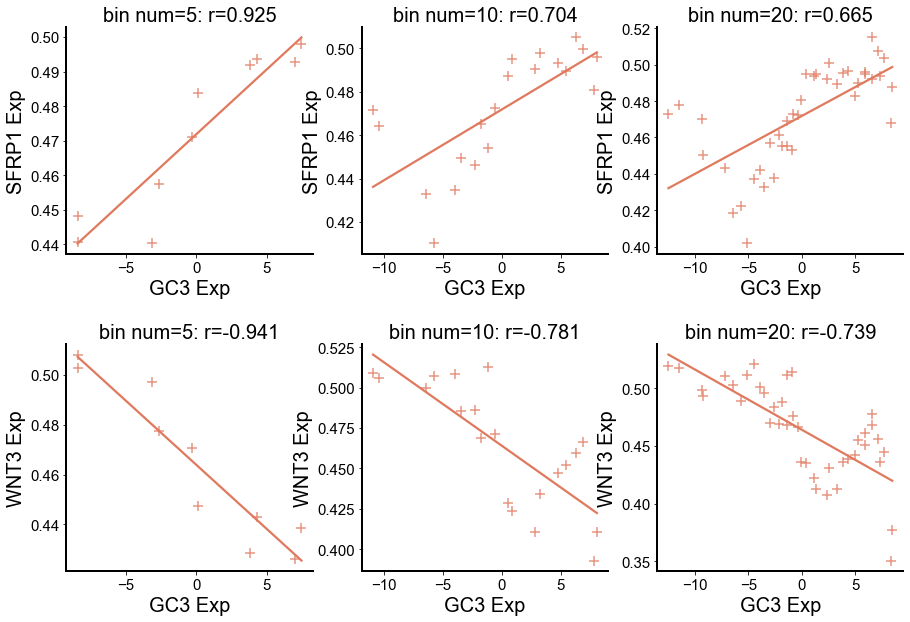

In [67]:
gene_name_1 = 'SFRP1'
gene_name_2 = 'WNT3'
gene_L = surface.load_surf_data(f'{gene_father}/GIFTI_L/{gene_name_1}.L.func.gii')
gene_R = surface.load_surf_data(f'{gene_father}/GIFTI_R/{gene_name_1}.R.func.gii')
gene_1 = np.concatenate([gene_L[select_ind_L], gene_R[select_ind_R]])

gene_L = surface.load_surf_data(f'{gene_father}/GIFTI_L/{gene_name_2}.L.func.gii')
gene_R = surface.load_surf_data(f'{gene_father}/GIFTI_R/{gene_name_2}.R.func.gii')
gene_2 = np.concatenate([gene_L[select_ind_L], gene_R[select_ind_R]])

gg=2
GC = emb[:,gg]

fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.4)
for bin_num in [5,10,20]:
    gene_1_bin = np.zeros(bin_num*2)
    gene_2_bin = np.zeros(bin_num*2)
    GC_bin = np.zeros(bin_num*2)

    for _bin in range(bin_num):
        # left hemisphere
        idx = np.argsort(emb_L[:, gg])[_bin*int(emb_L.shape[0]/bin_num):(_bin+1)*int(emb_L.shape[0]/bin_num)]
        gene_1_bin[_bin] = np.mean(gene_1[idx])
        gene_2_bin[_bin] = np.mean(gene_2[idx])
        GC_bin[_bin] = np.mean(emb_L[idx, gg])
        # right hemisphere
        idx = np.argsort(emb_R[:, gg])[_bin*int(emb_R.shape[0]/bin_num):(_bin+1)*int(emb_R.shape[0]/bin_num)]
        gene_1_bin[_bin + bin_num] = np.mean(gene_1[idx+29696])
        gene_2_bin[_bin + bin_num] = np.mean(gene_2[idx+29696])
        GC_bin[_bin + bin_num] = np.mean(emb_R[idx, gg])

    r1,p1 = pearsonr(gene_1_bin, GC_bin)
    r2,p2 = pearsonr(gene_2_bin, GC_bin)
    print(f'{gene_name_1}:{r1};{p1}\n{gene_name_2}:{r2};{p2}')

    tips = pd.DataFrame({'y':gene_1_bin, 'x':GC_bin})
    if bin_num== 5: ax = fig.add_subplot(231)
    if bin_num==10: ax = fig.add_subplot(232)
    if bin_num==20: ax = fig.add_subplot(233)
    fig = sns.regplot(x="x", y="y", \
                data=tips, \
                scatter_kws={'s':100}, \
                line_kws={'linestyle':'-'}, \
                ci = None, \
                marker='+', color='#E07A5f')
    plt.xlabel(f"GC{gg+1} Exp", fontsize=20)
    plt.ylabel(f"{gene_name_1} Exp", fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth('2.0')
    ax.spines['left'].set_linewidth('2.0')
    ax.tick_params(labelsize=15)
    fig = fig.get_figure()
    plt.title(f'bin num={bin_num}: r={np.round(r1,3)}', fontsize=20)

    tips = pd.DataFrame({'y':gene_2_bin, 'x':GC_bin})
    if bin_num== 5: ax = fig.add_subplot(234)
    if bin_num==10: ax = fig.add_subplot(235)
    if bin_num==20: ax = fig.add_subplot(236)
    fig = sns.regplot(x="x", y="y", \
                data=tips, \
                scatter_kws={'s':100}, \
                line_kws={'linestyle':'-'}, \
                ci = None, \
                marker='+', color='#E07A5f')
    plt.xlabel(f"GC{gg+1} Exp", fontsize=20)
    plt.ylabel(f"{gene_name_2} Exp", fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth('2.0')
    ax.spines['left'].set_linewidth('2.0')
    ax.tick_params(labelsize=15)
    fig = fig.get_figure()
    plt.title(f'bin num={bin_num}: r={np.round(r2,3)}', fontsize=20)
plt.show()

SFRP1:0.7809904060038618;0.0076539315273857515
WNT3:-0.7623592362168576;0.01035450987492864


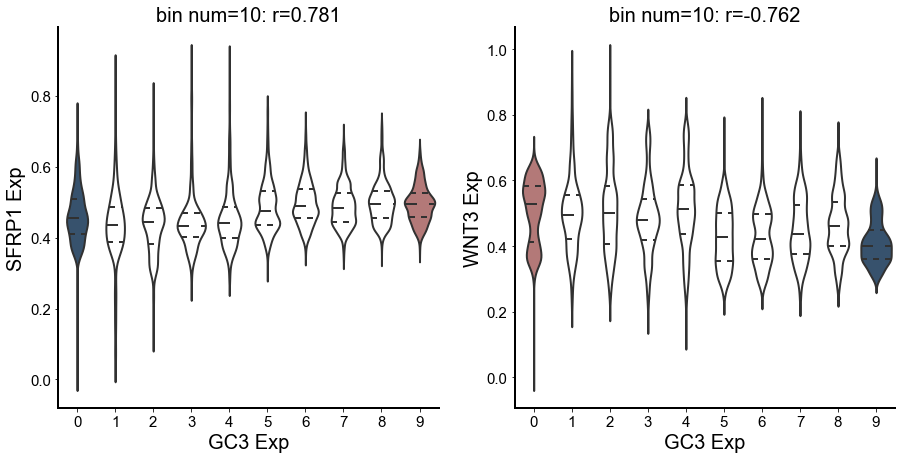

In [76]:
gene_name_1 = 'SFRP1'
gene_name_2 = 'WNT3'
gene_L = surface.load_surf_data(f'{gene_father}/GIFTI_L/{gene_name_1}.L.func.gii')
gene_R = surface.load_surf_data(f'{gene_father}/GIFTI_R/{gene_name_1}.R.func.gii')
gene_1 = np.concatenate([gene_L[select_ind_L], gene_R[select_ind_R]])

gene_L = surface.load_surf_data(f'{gene_father}/GIFTI_L/{gene_name_2}.L.func.gii')
gene_R = surface.load_surf_data(f'{gene_father}/GIFTI_R/{gene_name_2}.R.func.gii')
gene_2 = np.concatenate([gene_L[select_ind_L], gene_R[select_ind_R]])

gg=2
GC = emb[0:29696,gg]
gene_1 = gene_1[0:29696]
gene_2 = gene_2[0:29696]


fig = plt.figure(figsize=(15,7))
fig.subplots_adjust(hspace=0.4)
for bin_num in [10]:
    gene_1_bin = np.zeros(bin_num)
    gene_2_bin = np.zeros(bin_num)
    GC_bin = np.zeros(bin_num)
    gene_1_violin = np.zeros((29696, 2))
    gene_2_violin = np.zeros((29696, 2))

    for _bin in range(bin_num):
        # left hemisphere
        idx = np.argsort(emb_L[:, gg])[_bin*int(emb_L.shape[0]/bin_num):(_bin+1)*int(emb_L.shape[0]/bin_num)]
        gene_1_bin[_bin] = np.mean(gene_1[idx])
        gene_2_bin[_bin] = np.mean(gene_2[idx])
        GC_bin[_bin] = np.mean(emb_L[idx, gg])

        # violin
        gene_1_violin[idx,0] = int(_bin)
        gene_1_violin[idx,1] = gene_1[idx]
        gene_2_violin[idx,0] = int(_bin)
        gene_2_violin[idx,1] = gene_2[idx]

    r1,p1 = pearsonr(gene_1_bin, GC_bin)
    r2,p2 = pearsonr(gene_2_bin, GC_bin)
    print(f'{gene_name_1}:{r1};{p1}\n{gene_name_2}:{r2};{p2}')

    colors = ['#2e5276'] + ['#ffffff' for _ in range(bin_num-2)] + ['#bd706e']
    if bin_num==10: ax = fig.add_subplot(121)

    df = pd.DataFrame(np.array(gene_1_violin), columns=['bin','gene_exp'])
    df['bin'] = np.array(df['bin']).astype(np.int16)
    sns.violinplot(x ='bin', # 指定x轴的数据
               y = 'gene_exp', # 指定y轴的数据
               data = df, # 指定绘图的数据集
               orient='v',
               palette = colors,
               saturation = 0.75,
               bw='scott',
               inner='quartiles',
               linewidth=2)
    # plt.ylim(0.8,1)
    plt.xlabel(f"GC{gg+1} Exp", fontsize=20)
    plt.ylabel(f"{gene_name_1} Exp", fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth('2.0')
    ax.spines['left'].set_linewidth('2.0')
    ax.tick_params(labelsize=15)
    fig = fig.get_figure()
    plt.title(f'bin num={bin_num}: r={np.round(r1,3)}', fontsize=20)

    colors = ['#bd706e'] + ['#ffffff' for _ in range(bin_num-2)] + ['#2e5276']
    if bin_num==10: ax = fig.add_subplot(122)

    df = pd.DataFrame(np.array(gene_2_violin), columns=['bin','gene_exp'])
    df['bin'] = np.array(df['bin']).astype(np.int16)
    sns.violinplot(x ='bin', # 指定x轴的数据
               y = 'gene_exp', # 指定y轴的数据
               data = df, # 指定绘图的数据集
               orient='v',
               palette = colors,
               saturation = 0.75,
               bw='scott',
               inner='quartiles',
               linewidth=2)
    # plt.ylim(0.4,0.6)
    plt.xlabel(f"GC{gg+1} Exp", fontsize=20)
    plt.ylabel(f"{gene_name_2} Exp", fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth('2.0')
    ax.spines['left'].set_linewidth('2.0')
    ax.tick_params(labelsize=15)
    fig = fig.get_figure()
    plt.title(f'bin num={bin_num}: r={np.round(r2,3)}', fontsize=20)
plt.show()